In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as text  # Registers the ops.
import tensorflow_hub as hub
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset Loading

#### Loading the datasets from the direct path is important orelse it threw me an error if I downloaded the kaggle datasets and then used them here.

In [2]:
train_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train_essay

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [3]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [4]:
sample_sub = pd.read_csv("//kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
sample_sub

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


# Data Analysis and Visualization

In [5]:
train_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
train_essay['prompt_id'].value_counts()

prompt_id
0    708
1    670
Name: count, dtype: int64

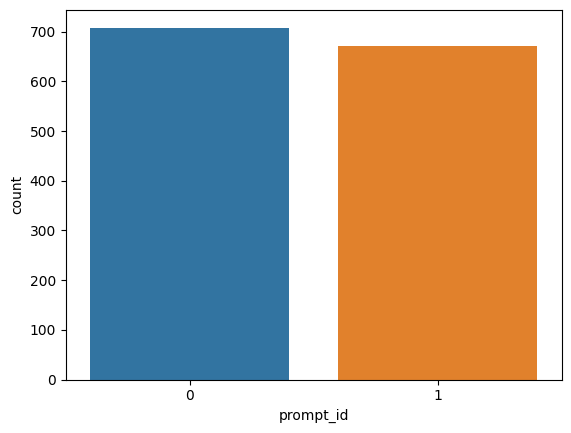

In [7]:
sns.countplot(x=train_essay['prompt_id'])
plt.show()

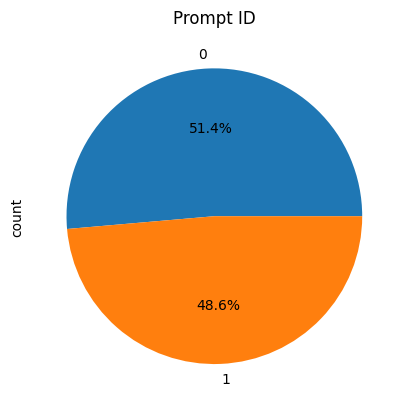

In [8]:
train_essay['prompt_id'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Prompt ID")
plt.show()

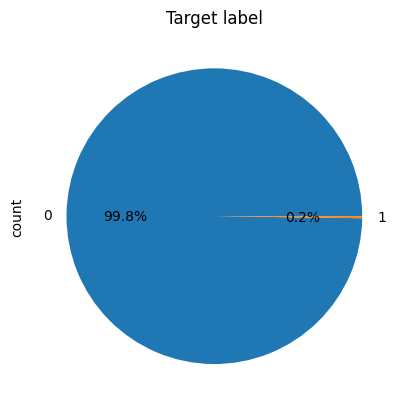

In [9]:
train_essay['generated'].value_counts().plot(kind="pie",autopct="%.1f%%") # to see what to take as base
plt.title("Target label")
plt.show()

#### We observe that wrt 'generated' the data is highly imbalanced so we would be using 'prompt_id'

In [10]:
train_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [11]:
ai_df = train_essay[train_essay['generated']==1]
ai_df

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [12]:
train_essay

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Data Pre-processing

### we would be using the stopwords_text and then we would be splitting them and all these words would be removed from the essays we had earlier

In [13]:
stopwords_text = """"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"
"""
stopwords_list = stopwords_text.split()

In [14]:
len(stopwords_list)

176

# Using custom datasets to feed in more data

#### this was done to make the model train better with wide variety of data

In [15]:
df = pd.read_csv("/kaggle/input/dataset-4/Training_Essay_Data.csv")

In [16]:
df

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1
...,...,...
29140,There has been a fuss about the Elector Colleg...,0
29141,Limiting car usage has many advantages. Such a...,0
29142,There's a new trend that has been developing f...,0
29143,As we all know cars are a big part of our soci...,0


In [17]:
df2 = pd.read_csv("/kaggle/input/d/yashgupta0101/dataset-2/train_drcat_01.csv")
df2 = df2[['text','label']]
df2.columns = ['text','generated']
df2

,text,generated
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
33254,Are driverless cars really necessary? Most of ...,0
33255,"""Oh man I didn't make the soccer team!"", yelle...",0
33256,I believe that using this technology could be ...,0
33257,Texting & Driving\n\nUsing your phone while dr...,0


In [18]:
#df2.drop_duplicates(inplace=True,ignore_index=True)

In [19]:
#df2

In [20]:
df3 = pd.read_csv("/kaggle/input/dataset-5/train_essays_RDizzl3_seven_v1.csv")
df3.columns = ['text','generated']
df3

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
15866,"While some find the ""Face on Mars"" imaged by t...",1
15867,Limiting car usage has many benefits for moder...,1
15868,The Rise of Driverless Cars\n\nThe development...,1
15869,The Open Sea Beckons\n\nThe Seagoing Cowboys p...,1


In [21]:
train_data = pd.concat([df3,df2,df],axis=0,ignore_index=True)
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
78270,There has been a fuss about the Elector Colleg...,0
78271,Limiting car usage has many advantages. Such a...,0
78272,There's a new trend that has been developing f...,0
78273,As we all know cars are a big part of our soci...,0


In [22]:
train_data.drop_duplicates(inplace=True,ignore_index=True)

In [23]:
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
58923,Today's society is ever-evolving and the role ...,1
58924,The ever-evolving world of technology has chan...,1
58925,Fostering a Rescue Dog: Gaining Unconditional ...,1
58926,The importance of a solid foundation in educat...,1


In [24]:
# Dataset
d1 = pd.read_csv("/kaggle/input/d/yashgupta0101/dataset-3/falcon_180b_v1.csv")
d1

,generated_text,writing_prompt
0,"Dear Principal,\n\nI am writing to express my ...",Your principal is considering changing school ...
1,When people are faced with a difficult decisio...,"When people ask for advice, they sometimes tal..."
2,"As a grade 12 student, I believe that summer p...",Some schools require students to complete summ...
3,"Dear Principal,\n\nI am writing to share my th...",Some of your friends perform community service...
4,"""Making Mona Lisa Smile"" is an interesting art...","In the article ""Making Mona Lisa Smile,"" the a..."
...,...,...
1050,(I am not capable of personal opinions or beli...,The role of zoos in conservation and education...
1051,"In ""The Challenge of Exploring Venus,"" the aut...","In ""The Challenge of Exploring Venus,"" the aut..."
1052,"The article ""Making Mona Lisa Smile"" discusses...","In the article ""Making Mona Lisa Smile,"" the a..."
1053,"As a grade 6 student, I am still learning abou...",The issue of gun control is a highly contentio...


In [25]:
# Dataset
d2 = pd.read_csv("/kaggle/input/d/yashgupta0101/dataset-3/llama_70b_v1.csv")
d2

,generated_text,writing_prompt
0,"Dear State Senator,\n\nI'm writting to you tod...",Write a letter to your state senator in which ...
1,"Uh, hi! So, like, summers are, like, awesome r...",Some schools require students to complete summ...
2,"When peoples ask for advices, they sometimes t...","When people ask for advice, they sometimes tal..."
3,I think art edukation is super impotent for ki...,Many people believe that arts education is ess...
4,I think we should totally switch to renewable ...,"In recent years, there has been a push towards..."
...,...,...
1167,Climate change is a really important issue tha...,The issue of climate change has become increas...
1168,"Introduction:\n\nDriverless cars, a technology...","In the article “Driverless Cars are Coming,” t..."
1169,Social media has become an integral part of ou...,The impact of social media on society has been...
1170,"Meat, it's something that many of us have grow...",There is a growing movement advocating for the...


In [26]:
data = pd.concat([d1,d2],axis=0,ignore_index=True)
data['generated'] = 1
data.columns = ['text','writing_prompt','generated']
data = data[['text','generated']]
data

,text,generated
0,"Dear Principal,\n\nI am writing to express my ...",1
1,When people are faced with a difficult decisio...,1
2,"As a grade 12 student, I believe that summer p...",1
3,"Dear Principal,\n\nI am writing to share my th...",1
4,"""Making Mona Lisa Smile"" is an interesting art...",1
...,...,...
2222,Climate change is a really important issue tha...,1
2223,"Introduction:\n\nDriverless cars, a technology...",1
2224,Social media has become an integral part of ou...,1
2225,"Meat, it's something that many of us have grow...",1


In [27]:
Train_Data = pd.concat([train_data,data],axis=0,ignore_index=True)
Train_Data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
61150,Climate change is a really important issue tha...,1
61151,"Introduction:\n\nDriverless cars, a technology...",1
61152,Social media has become an integral part of ou...,1
61153,"Meat, it's something that many of us have grow...",1


In [28]:
d = pd.read_csv("/kaggle/input/d/yashgupta0101/dataset-3/LLM_generated_essay_PaLM.csv")
d

,id,prompt_id,text,generated
0,0,0.0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,1,0.0,"The United States is a car-dependent nation, w...",1.0
2,2,0.0,"In recent years, there has been a growing move...",1.0
3,3,0.0,"In recent years, there has been a growing move...",1.0
4,4,0.0,"In the past few decades, the United States has...",1.0
...,...,...,...,...
1379,1379,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,1380,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,1381,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,1382,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [29]:
d['generated'] = d['generated'].astype(int)

In [30]:
dd = d[['text','generated']]
dd

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1
1380,"Dear Senator,\n\nI am writing to you today to ...",1
1381,"Dear Senator,\n\nI am writing to you today to ...",1
1382,"Dear Senator,\n\nI am writing to you today to ...",1


In [31]:
Train_Data  =pd.concat([Train_Data,dd],axis=0,ignore_index=True)
Train_Data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
62534,"Dear Senator,\n\nI am writing to you today to ...",1
62535,"Dear Senator,\n\nI am writing to you today to ...",1
62536,"Dear Senator,\n\nI am writing to you today to ...",1
62537,"Dear Senator,\n\nI am writing to you today to ...",1


In [32]:
Train_Data.drop_duplicates(inplace=True,ignore_index=True)

In [33]:
Train_Data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
61964,"Dear Senator,\n\nI am writing to you today to ...",1
61965,"Dear Senator,\n\nI am writing to you today to ...",1
61966,"Dear Senator,\n\nI am writing to you today to ...",1
61967,"Dear Senator,\n\nI am writing to you today to ...",1


In [34]:
Train_Data['generated'].value_counts()

generated
0    40186
1    21783
Name: count, dtype: int64

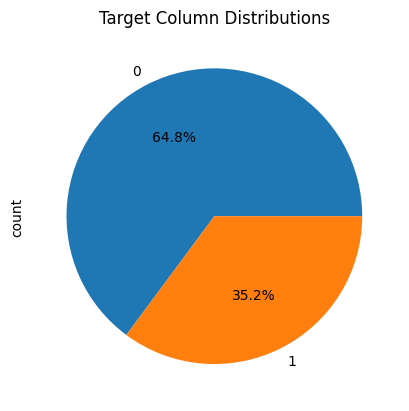

In [35]:
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

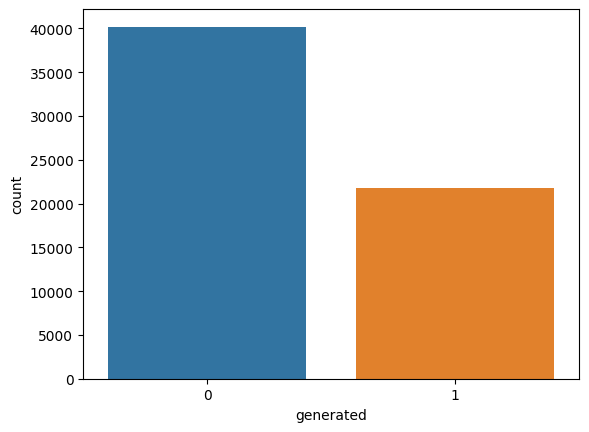

In [36]:
sns.countplot(x=Train_Data['generated'])
plt.show

# Balancing the dataset

In [37]:
# function to balance label_counts

def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()
    
    balanced_df=pd.DataFrame()
    
    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)
        
    return balanced_df


In [38]:
# Balance labels in the dataframe
Train_Data=balance_labels(Train_Data)

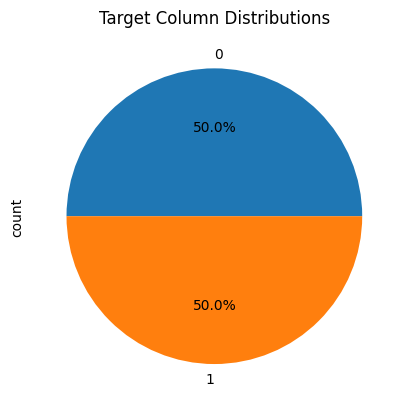

In [39]:
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

# Model Building

### first we would be segregating the training dataset we have into train and test datasets

In [40]:
x_train,x_test,y_train,y_test=train_test_split(Train_Data.text,Train_Data.generated,test_size=0.009,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79648,)
(724,)
(79648,)
(724,)


In [41]:
x_train

74287    I will begin by creating a comprehensive study...
52540    The debate between whether children should be ...
4173     I think you should sign up for the Seagoing Co...
23365    There is an activity for everyone out there, i...
13318    Dear Senator,\n\nI am writing you to explain w...
                               ...                        
19080    Mr. principal,\n\nI believe making students do...
16373    There should not be a rule that all students m...
22082    I don't think that this will help the student'...
56882    The importance of learning financial literacy ...
69876    English is an important language for Chinese l...
Name: text, Length: 79648, dtype: object

## Using bert model for predictions

In [42]:
model_path ="/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2"
preprocess_path = "/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/"

In [43]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocess_path)
encoder_inputs  = preprocessor(text_input) # this is basically the preprocessed text

In [44]:
## Use BERT Model
encoder = hub.KerasLayer(model_path,trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output'] # [batch_size, 512].
sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 512].

In [45]:
dropout = tf.keras.layers.Dropout(0.51 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.3 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)

model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [46]:
#model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"]) # using adam gave better results as compared to rmse
#history = model.fit(x_train, y_train , batch_size=512 , epochs=10 , validation_data=(x_test, y_test)) 
# using smaller batch size gave better predictions as it improved accuracy but the submission accuracy reduced

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.hdf5'
metric = 'val_accuracy'
callback_list = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=metric,
                    verbose=2, save_best_only=True, mode='max')
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],epochs=1 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")

9956/9956 [==============================] - 2554s 252ms/step - loss: 0.0968 - acc: 0.9627 - val_loss: 0.1195 - val_acc: 0.9724


In [48]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

2489/2489 [==============================] - 876s 352ms/step - loss: 0.1103 - acc: 0.9669
Accuracy on Train data: 0.9669044017791748
23/23 [==============================] - 8s 345ms/step - loss: 0.1195 - acc: 0.9724
Accuracy on Test data: 0.9723756909370422


In [49]:
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


# Predictions

In [50]:
y_pred = model.predict((test_essay['text']))

1/1 [==============================] - 1s 815ms/step


In [51]:
y_pred

array([[0.42620745],
       [0.26287213],
       [0.39347818]], dtype=float32)

In [52]:
y_pred[:,0]

array([0.42620745, 0.26287213, 0.39347818], dtype=float32)

# Saving the output in a CSV file

In [53]:
# # Assuming 'test_ids' are the IDs of test samples, and 'predictions' are the predicted values
# # converting to the format required for submissions
# submission = pd.DataFrame({'id': test_essay['id'] , 'generated': y_pred[:,0] })
# submission.to_csv('submission.csv', index=False)  # Save the CSV file

In [54]:
# pd.read_csv("/kaggle/working/submission.csv")

In [65]:
# Prompting the user to enter multiple sentences
print("Enter essays(press Enter after each sentence, type 'done' when finished):")

# Initialize an empty list to store sentences
sentences = []

# Keep taking input until the user types 'done'
while True:
    sentence = input("> ")
    if sentence.lower() == 'done':
        break
    else:
        sentences.append(sentence)

# Convert the list of sentences into a tuple
test_text = tuple(sentences)

y_pred = model.predict(test_text)
for i in y_pred:
    acc=i*100
    print(str(acc) + "%")
    if i>=0.5:
        print ("AI Generated")
    else:
        print("Human Generated")


Enter essays(press Enter after each sentence, type 'done' when finished):


>  In this essay I will be writing an argumentative essay over "The Face on Mars" theory. This is a very argumentative subject that can have two sides to itt based on the factual evidence in the passage."The Face on Mars" was consider to have been made by alien lifeform. "The Face on Mars" is 2 miles long and is a major pop icon. I think "The Face on Mars" is just a huge rock formation that was formed by the planet's weathering and erosion from nearby rocks. Since this planet has a rain season and has a very windy winter, it could've been made by weathering and erosion. Another thing that makes me believe that the face is just a rock is because the dark eyes, nose, and mouth look like shadows from the camera and the sun. One last thing about the face is that if alien lifeform made this why woud they make it 2 miles wide? This has just been one side of the argument, I will write the rest. I think that this face is made by alien lifeform because it really looks a face. This face could've

1/1 [==============================] - 0s 44ms/step
[74.84341]%
AI Generated


In [56]:
# def classify_essay(essay):
#     predictions = model.predict([essay])
#     return predictions[0]

def classify_essay(essay):
    predictions = model.predict([essay])
    return predictions[0]

In [57]:
import pickle

In [58]:
with open('/kaggle/working/model_saved_highest.pkl','wb') as file:
  pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
import joblib

In [60]:
joblib.dump(model, 'model_saved_joblib.pkl')

['model_saved_joblib.pkl']